## Introduction

### Definitions

##### Global Blocktree
A global tree maintained during the simulation used to determine certain statistics

##### Node Tree
A Node has a tree structure consisting of tree blocks just like in the Longest Chain Protocol.

##### Main Chain
On a tree structure, the main chain is defined in this protocol as the Longest Chain from the Genesis block to a leaf block.

##### Node Pool
A node also has a pool structure consisting of pool blocks. 

##### Tree Block
A block on the global blocktree or in a node's local tree.

##### Pool Block
A block in a node's local pool. The block may or may not be referenced by the next tree block proposed by the node.

##### Finalized
A block is considered finalized in two cases:

1) If in a tree block - if the block is `k` blocks deep on the main chain
2) If in a pool block - if the pool block is referenced by a tree block that is finalized

A transaction is considered finalized if it is in a finalized block

## Simulation Description

We measure multiple metrics to understand a transactions behavior during the simulation. 

#### Throughput
How many of the transactions generated actually get finalized in the simulation? 

#### Pool Block Arrival Latency
How long does it take for a transaction to make it into a pool block and get referenced?

#### Main Chain Arrival Latency
How long does it take for a transaction to make it onto the main chain?

#### Finalization Latency
How long does it take for a transaction to be finalized once it arrives on the main chain?


### Experimental Parameters

In [1]:
import numpy as np
%matplotlib inline

num_tests = 5

tree_proposal_rates = np.linspace(0.1, 0.1, num_tests)
pool_proposal_rates = np.linspace(0.1, 1, num_tests)
n_trials = 1
import json

# Create experimental parameters and write to JSON file

params = {'Block tree proposal rate parameter': 0,
 'Block pool proposal rate parameter': 0,
 'Block size (txs)': 50,
 'Duration (sec)': 0,
 'Fork choice rule': 'longest-chain-with-pool',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson',
 'Logging enabled': True}

### Run experiments

In [2]:
import os, shutil, pprint, glob, csv

pp = pprint.PrettyPrinter()
os.system('touch longest_chain_with_pool.json')
os.chdir('..')

import metrics

throughputs = {}
main_chain_arrival_latencies = {}
pool_block_latencies = {}
finalization_latencies = {}
hist_data = {}

for i in range(0, num_tests):
    tree_rate = tree_proposal_rates[i]
    pool_rate = pool_proposal_rates[i]
    params['Block tree proposal rate parameter'] = tree_rate
    params['Block pool proposal rate parameter'] = pool_rate
    params['Duration (sec)'] = 1000
    d = {}
    d['setting-name'] = f'longest-chain-with-pool'
    d[f'longest-chain-with-pool'] = params
    print('Parameters:')
    pp.pprint(d)
    with open('results/longest_chain_with_pool.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[(tree_rate, pool_rate)] = []
    main_chain_arrival_latencies[(tree_rate, pool_rate)] = []
    pool_block_latencies[(tree_rate, pool_rate)] = []
    finalization_latencies[(tree_rate, pool_rate)] = []
    for trial in range(0, n_trials):
        os.system('python3 main.py -f results/longest_chain_with_pool.json')
        throughput = metrics.compute_throughput()
        avg_main_chain_arrival_latency, avg_pool_block_latency, avg_finalization_latency = metrics.compute_latency()
        throughputs[(tree_rate, pool_rate)].append(throughput)
        main_chain_arrival_latencies[(tree_rate, pool_rate)].append(avg_main_chain_arrival_latency)
        pool_block_latencies[(tree_rate, pool_rate)].append(avg_pool_block_latency)
        finalization_latencies[(tree_rate, pool_rate)].append(avg_finalization_latency)
    
os.chdir('results/')
os.remove('longest_chain_with_pool.json')
print('Throughputs:\n', throughputs)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Pool Block Latencies:\n', pool_block_latencies)
print('Finalization Latencies:\n', finalization_latencies)

Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.1,
                             'Block size (txs)': 50,
                             'Block tree proposal rate parameter': 0.1,
                             'Duration (sec)': 1000,
                             'Fork choice rule': 'longest-chain-with-pool',
                             'Logging enabled': True,
                             'Network model': 'Decker-Wattenhorf',
                             'Number of adversaries': 1,
                             'Number of nodes': 100,
                             'Probability of error in transaction confirmation': 0.1,
                             'Transaction dataset': 'poisson'},
 'setting-name': 'longest-chain-with-pool'}
Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.325,
                             'Block size (txs)': 50,
                             'Block tree proposal rate parameter': 0.1,
                          

### Compute Averages

Average throughput is the number of finalized transactions divided by the duration of the experiment.

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was generated.

Average pool block latency is the time for a transaction to be added to a pool block AND referenced by a tree block.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [3]:
avg_throughputs = {}
for rate in throughputs:
    avg_throughputs[rate] = sum(throughputs[rate])/len(throughputs[rate])

print("Average Throughputs:", avg_throughputs)
    
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)

avg_pool_block_latencies = {}
for rate in pool_block_latencies:
    avg_pool_block_latencies[rate] = sum(pool_block_latencies[rate])/len(pool_block_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)

avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)

Average Throughputs: {(0.1, 0.1): 10.06, (0.1, 0.325): 10.02, (0.1, 0.55): 10.19, (0.1, 0.775): 10.48, (0.1, 1.0): 9.46}
Average Main Chain Arrival Latency: {(0.1, 0.1): 13.862931220902533, (0.1, 0.325): 23.493728216105467, (0.1, 0.55): 20.470359346467184, (0.1, 0.775): 28.93748684569044, (0.1, 1.0): 22.86201526380925}
Average Main Chain Arrival Latency: {(0.1, 0.1): 13.862931220902533, (0.1, 0.325): 23.493728216105467, (0.1, 0.55): 20.470359346467184, (0.1, 0.775): 28.93748684569044, (0.1, 1.0): 22.86201526380925}
Average Finalization Latency: {(0.1, 0.1): 36.23115087414979, (0.1, 0.325): 21.40372394735098, (0.1, 0.55): 15.569164506527523, (0.1, 0.775): 12.84582471110266, (0.1, 1.0): 11.29021304209736}


### Extract Finalization Depth and Delta for Blocks

In [4]:
import csv
with open('../logs/stats.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0]=='Finalization depth':
            k = int(row[1])
        elif row[0]=='Average network latency for blocks (sec)':
            delta = float(row[1])

### Plotting the results

In [5]:
import matplotlib.pylab as plt
x = [key[1] for key in avg_main_chain_latencies.keys()]
y1 = avg_throughputs.values()
y2 = avg_main_chain_latencies.values()
y3 = avg_pool_block_latencies.values()
y4 = avg_finalization_latencies.values()

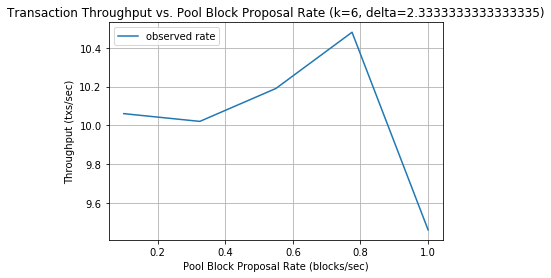

In [6]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Throughput (txs/sec)')
plt.title(f'Transaction Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y1, label='observed rate')
plt.legend()
plt.show()

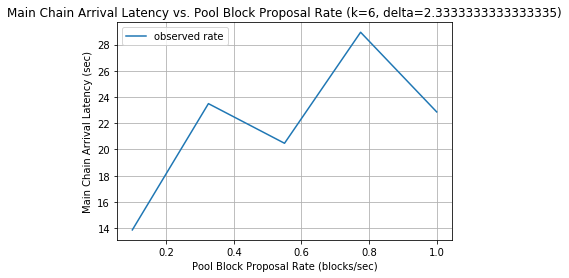

In [7]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title(f'Main Chain Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.legend()
plt.show()

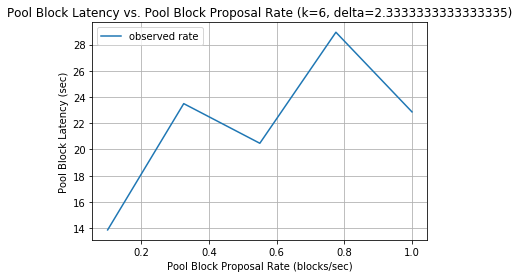

In [8]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Pool Block Latency (sec)')
plt.title(f'Pool Block Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.legend()
plt.show()

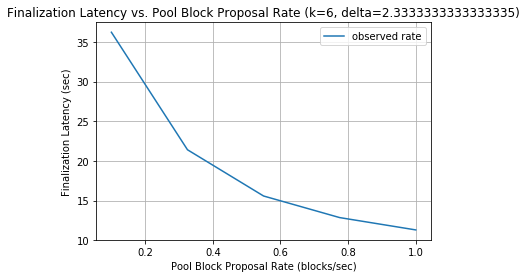

In [9]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Finalization Latency (sec)')
plt.title(f'Finalization Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)
plt.plot(x, y4, label='observed rate')
plt.legend()
plt.show()

### Results

We can look through the logs to understand the process a transaction undergoes. A transaction can

1) Be a pool or a tree transaction
2) Be on the main chain or not on the main chain
3) Be finalized or not finalized

Hence, we will analyze each of the following cases:
1) A pool transaction on the main chain that is finalized
2) A pool transaction not on the main chain
3) A tree transaction on the main chain that is finalized
4) A tree transaction on the main chain that is not finalized
5) A tree transaction not on the main chain

In [10]:
import csv

finalized_main_chain_pool_tx = None
not_on_main_chain_pool_tx = None
finalized_main_chain_tree_tx = None
unfinalized_main_chain_tree_tx = None
not_on_main_chain_tree_tx = None

with open('../logs/transactions.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    row_count = 0
    for row in reader:
        if row['finalization timestamp']!='None'and row['main chain arrival timestamp']!='None' and row['pool block timestamp']!='None' and finalized_main_chain_pool_tx==None:
            finalized_main_chain_pool_tx = row
        elif row['main chain arrival timestamp']=='None' and row['pool block timestamp']!='None' and not_on_main_chain_pool_tx==None:
            not_on_main_chain_pool_tx = row
        elif row['finalization timestamp']!='None' and row['main chain arrival timestamp']!='None' and row['pool block timestamp']=='None' and finalized_main_chain_tree_tx==None:
            finalized_main_chain_tree_tx = row
        elif row['finalization timestamp']=='None' and row['main chain arrival timestamp']!='None' and row['pool block timestamp']=='None' and unfinalized_main_chain_tree_tx==None:
            unfinalized_main_chain_tree_tx = row
        elif row['main chain arrival timestamp']=='None' and row['pool block timestamp']=='None' and not_on_main_chain_tree_tx==None: 
            not_on_main_chain_tree_tx = row
        if row_count<10:
            print(row)
        row_count+=1

OrderedDict([('id', '004dd836b1'), ('source node', '48'), ('generated timestamp', '1.947375099509406'), ('main chain arrival timestamp', '24.990065286096694'), ('pool block timestamp', '24.990065286096694'), ('finalization timestamp', '33.683586222187515')])
OrderedDict([('id', '44f0384094'), ('source node', '4'), ('generated timestamp', '3.409642689310917'), ('main chain arrival timestamp', '24.990065286096694'), ('pool block timestamp', '24.990065286096694'), ('finalization timestamp', '33.683586222187515')])
OrderedDict([('id', 'd544d29b3d'), ('source node', '63'), ('generated timestamp', '5.487714404466631'), ('main chain arrival timestamp', '24.990065286096694'), ('pool block timestamp', '24.990065286096694'), ('finalization timestamp', '33.683586222187515')])
OrderedDict([('id', '77a5fd6dc2'), ('source node', '36'), ('generated timestamp', '6.151962108970177'), ('main chain arrival timestamp', '24.990065286096694'), ('pool block timestamp', '24.990065286096694'), ('finalization t

In [11]:
print(f'Finalized Pool Transaction:\n{finalized_main_chain_pool_tx}')
print(f'Pool Transaction Not on Main Chain:\n{not_on_main_chain_pool_tx}')
print(f'Finalized Tree Transaction:\n{finalized_main_chain_tree_tx}')
print(f'Unfinalized Tree Transaction:\n{unfinalized_main_chain_tree_tx}')
print(f'Tree Transaction Not on Main Chain:\n{not_on_main_chain_tree_tx}')


Finalized Pool Transaction:
OrderedDict([('id', '004dd836b1'), ('source node', '48'), ('generated timestamp', '1.947375099509406'), ('main chain arrival timestamp', '24.990065286096694'), ('pool block timestamp', '24.990065286096694'), ('finalization timestamp', '33.683586222187515')])
Pool Transaction Not on Main Chain:
OrderedDict([('id', '3c9dff441a'), ('source node', '37'), ('generated timestamp', '987.8300509290495'), ('main chain arrival timestamp', 'None'), ('pool block timestamp', '1008.6670080477315'), ('finalization timestamp', 'None')])
Finalized Tree Transaction:
OrderedDict([('id', '417a5d959f'), ('source node', '24'), ('generated timestamp', '194.39799836782905'), ('main chain arrival timestamp', '198.94309204188485'), ('pool block timestamp', 'None'), ('finalization timestamp', '216.24682927954015')])
Unfinalized Tree Transaction:
None
Tree Transaction Not on Main Chain:
OrderedDict([('id', 'c8d8a6e1c9'), ('source node', '33'), ('generated timestamp', '997.8279580986352'

Let's consider the first case of the finalized pool transaction. If we look into `blocks.csv`,
we should be able to see that the transaction's main chain arrival timestamp and pool block timestamp
should be equivalent to a tree block's proposal time. Additionally, the finalization time should be
the tree block's finalization time.

In [12]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if finalized_main_chain_pool_tx!=None:
        for row in reader:
            if finalized_main_chain_pool_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', 'd6cae'), ('parent id', 'Genesis'), ('proposal timestamp', '18.60267012319524'), ('pool block timestamp', 'None'), ('finalization timestamp', '31.81302138968443'), ('depth', '1'), ('finalized', 'True'), ('transactions', '004dd836b1;44f0384094;d544d29b3d;77a5fd6dc2;a542ef44ea;77852e2faa;d26dcd2df5;eb702f6ae2;1a822845a6;9d3f839701;494aaf938a;34083c442c')])


Now let's consider the second case of the pool transaction not on the main chain.
We should see that it belongs to a block that is not finalized and not on the main chain, indicated
by the fact the block's finalization timestamp and main chain arrival timestamp will both be `'None'`. However, the pool block timestamp should be equal to the block's proposal timestamp.

In [13]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if not_on_main_chain_pool_tx!=None:
        for row in reader:
            if not_on_main_chain_pool_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', '72dea'), ('parent id', '1e344'), ('proposal timestamp', '1008.6670080477315'), ('pool block timestamp', 'None'), ('finalization timestamp', 'None'), ('depth', '76'), ('finalized', 'False'), ('transactions', '3c9dff441a;4f1113e55c;e1492adb84;36bad9c656;4118951726;97dfd8ea0b;4202de7a48;83d310a56f;f9455e2214;c8d8a6e1c9;733130297b;a382d37750')])


The third case is the tree finalized tree transaction on the main chain. We should see that it
belongs to a block with equal finalization and main chain arrival timestamps, but a pool block timestamp equal to `'None'`.

In [14]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if finalized_main_chain_tree_tx!=None:
        for row in reader:
            if finalized_main_chain_tree_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', 'ddc17'), ('parent id', '6a7c4'), ('proposal timestamp', '198.94309204188485'), ('pool block timestamp', 'None'), ('finalization timestamp', '216.24682927954015'), ('depth', '16'), ('finalized', 'True'), ('transactions', '1ed712c6b3;74fb4a8399;eae248b65e;6f3a2b4f48;4ec485e4c4;0ab809ef64;25298fb37f;e2fd420912;460b6d4f32;6df525836b;5f2fcde24b;a802ba083c;321bf6fb4a;66fa2a5fd6;da7c9b8e8d;08aeeff71e;1930263345;bfc905df4d;d3398c2f63;5c813c5330;2d00b311bc;41208beb53;d4127d162f;9c608e4606;82c8ca1541;1a2a818d82;9e9f34c56c;6ce3d4f32e;a303987f25;5fe7c4337a;417a5d959f;4e6223ea4d;dd074a348e;d18b44a3af;33441694d7;92a21ee99c;6154538e76;96eeffc943')])


The fourth case is the unfinalized tree transaction on the main chain. We should see that it
belongs to a block with equal main chain arrival timestamp, but pool block and finalization
timestamps equal to `'None'`.

In [15]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if unfinalized_main_chain_tree_tx!=None:
        for row in reader:
            if unfinalized_main_chain_tree_tx['id'] in row['transactions']:
                print(row)
                break

The final case is the tree transaction not on the main chain. The block is not used for any statistics and is not logged.